In [4]:
#!pip install --upgrade pip 
#!pip install scikit-learn --upgrade 
#!pip install numpy --upgrade 
#!pip install pandas --upgrade 
#!pip install matplotlib
#!pip install imblearn
from time import time
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

## Στοιχέια Ομάδας

Ομάδα: A18
Καλογεράς Ανδρέας (03114822)
Λούρας Χρήστος (03114037)

## Εισαγωγή του Dataset

1. Το Dataset που θα χρησιμοποιήσουμε, αφορά τη μελέτη του εγκεφαλογραφήματος. Πιο συγκεκριμένα, θα επεξεργαστούμε δεδομένα που συλλέχθηκαν από έναν υγιή 25χρονο, ο οποίος υποβλήθηκε σε ηλεκτροεγκεφαλογράφημα 5 φορές σε διάστημα μερικών ημερών. Οι καταστάσεις στις οποίες θα εκπαιδεύσουμε τους classifiers μας είναι η κατάσταση 1 (Planning during imagination of motor act) και η κατάσταση 2(Relax State).

2. Το εν λόγω dataset περιέχει 182 δείγματα, τα οποία περιγράφονται από 13 στήλες. Στο αρχικό σήμα από το εγκεφαλογράφημα έγινε Wavelet Packet Analysis και προέκυψαν 12 wavelet coefficients (εύρος συχνοτήτων 7-13Hz στο 6ο level node) των οποίων οι τιμές βρίσκονται στα πρώτα 12 χαρακτηριστικά του dataset.

3. Δέν υπάρχουν επικεφαλίδες στο dataset μας, ούτε αρίθμηση των δειγμάτων.

4. Οι ετικέτες βρίσκονται στην 13η στήλη και όπως βλέπουμε παρακάτω έχουν 2 τιμές : 1 -> Planning State, 2 -> Relax State.

Αρχικά, διαβάζουμε το αρχείο plrx.txt στο οποίο είναι το dataset και το αποθηευούμε στον πίνακα df

In [5]:
df = pd.read_csv("plrx.txt", header=None, sep='\t' )
# in a second dataframe we keep only the collumns who matter(12 + 1)
df2 = df.iloc[:, :13]

Αποθηκέυουμε τα χαρακτηριστικά στον πίνακα features και τις ετικέτες(13 στήλη) στον πίνακα labels:

In [6]:
features = df.iloc[:, :12]
print(features)

labels = np.array(df.iloc[:, 12])

           0         1         2         3         4         5         6   \
0   -0.179360 -0.207000 -0.209710 -0.097260 -0.119210 -0.173220 -0.280760   
1   -0.146590 -0.164940  0.249870 -0.073985  0.494940 -0.156330 -0.288910   
2   -0.131310  0.518160  0.432810  0.397890  0.043127  0.563200 -0.013246   
3    0.649400  0.418780  0.148350  0.333490 -0.219740  0.398910  0.590650   
4   -0.406280  0.115030  0.073336  0.070066 -0.030920  0.152050 -0.191420   
5    0.278040  0.310110  0.206630  0.055255  0.162880  0.173560  0.607320   
6   -0.026340  0.262390  0.585810  0.546490  0.521440  0.213580  0.251060   
7    0.281990  0.085019  0.432290  0.335620  0.495590  0.010800  0.407180   
8    0.964050 -0.003361 -0.868760 -0.760130 -0.784820 -0.216680  0.847480   
9    0.818760  0.332390 -0.594130 -0.765170 -0.652960  0.132260  0.728830   
10   0.120990 -0.012491  0.237690  0.015010  0.242720  0.060151 -0.038016   
11   0.461080  0.465300  0.931170  0.889990  0.687710  0.455770  0.486050   

5. Για μεγαλύτερη ευκολία στη χρήση δεδομένων, μετατρέπουμε τις τιμές 1.0, 2.0 σε 0 , 1 αντίστοιχα:

In [7]:
labels = labels.astype(int) - 1
print(labels)

[0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


6. Δεν απουσιάζουν τιμές. Tο dataset είναι πλήρες.

7. Έχουμε 2 κλάσεις: 1, 2 (όπου 0 αντιστοιχεί σε 1.0 και 1 σε 2.0)

In [8]:
labels_size = labels.shape
counts = np.bincount(labels)
freqs = counts / labels_size
print("Frequency of 1.0 =",freqs[0]*100,"%")
print("Frequency of 2.0 =",freqs[1]*100,"%")

Frequency of 1.0 = 71.42857142857143 %
Frequency of 2.0 = 28.57142857142857 %


Συχνότητα του 1.0 είναι ~71.4% kai του 2.0 είναι ~28.6%. Επομένως το dataset δεν είναι ισορροπημένο.

Στην συνέχεια χωρίζουμε το dataset σε Train και Test set:

In [23]:
train, test, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.20)

## Baseline classification

1. Πρώτα εκπαιδεύουμε τους dummy ταξινομητές:

Παρακάτω είναι ο κώδικας για τους dummy estimators. Κάθε στρατηγική παρουσιάζεται σε διαφορετικά κελιά και παράλληλα τοποθετούμε τα αποτελέσματα σε κατάλληλες μεταβλητές και dictionaries (σε αυτά θα αποθηκευτούν και τα αποτελέσματα του kNN).

In [10]:
# Dictionary for the results of the Classifiers
baseline_f1_micro = {}
baseline_f1_macro = {}

i. Uniform:

In [11]:
# Uniform
dc_uniform = DummyClassifier(strategy="uniform")
model = dc_uniform.fit(train, train_labels)
pred = dc_uniform.predict(test)
# save confusion_matrix, f1 micro and f1 macro
uni_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['uniform'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['uniform'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix:\n" ,uni_conf_matrix, "\n")
print("F1_micro score:", baseline_f1_micro['uniform'])
print("F1_macro score: ", baseline_f1_macro['uniform'], "\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))


Confusion matrix:
 [[13 15]
 [ 4  5]] 

F1_micro score: 0.4864864864864865
F1_macro score:  0.46130268199233715 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.76      0.46      0.58        28
           1       0.25      0.56      0.34         9

   micro avg       0.49      0.49      0.49        37
   macro avg       0.51      0.51      0.46        37
weighted avg       0.64      0.49      0.52        37



ii. Constant 0:

In [12]:
# Constant 0
dc_constant_0 = DummyClassifier(strategy="constant", constant=0)
model = dc_constant_0.fit(train, train_labels)
pred = dc_constant_0.predict(test)
# save confusion_matrix, f1 micro and f1 macro
const_0_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['constant 0'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['constant 0'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix:\n", const_0_conf_matrix, "\n")
print("F1_micro score:", baseline_f1_micro['constant 0'])
print("F1_macro score:", baseline_f1_macro['constant 0'], "\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Confusion matrix:
 [[28  0]
 [ 9  0]] 

F1_micro score: 0.7567567567567567
F1_macro score: 0.4307692307692308 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        28
           1       0.00      0.00      0.00         9

   micro avg       0.76      0.76      0.76        37
   macro avg       0.38      0.50      0.43        37
weighted avg       0.57      0.76      0.65        37



iii. Constant 1:

In [13]:
# Constant 1
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
model = dc_constant_1.fit(train, train_labels)
pred = dc_constant_1.predict(test)
# save confusion_matrix, f1 micro and f1 macro
const_1_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['constant 1'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['constant 1'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix\n", const_1_conf_matrix, "\n")
print("F1_micro score:", baseline_f1_micro['constant 1'])
print("F1_macro score:", baseline_f1_macro['constant 1'], "\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Confusion matrix
 [[ 0 28]
 [ 0  9]] 

F1_micro score: 0.24324324324324326
F1_macro score: 0.1956521739130435 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.24      1.00      0.39         9

   micro avg       0.24      0.24      0.24        37
   macro avg       0.12      0.50      0.20        37
weighted avg       0.06      0.24      0.10        37



iv. Most Frequent:

In [14]:
# Most Frequent
dc_most_frequent = DummyClassifier(strategy="most_frequent")
model = dc_most_frequent.fit(train, train_labels)
pred = dc_most_frequent.predict(test)
# save confusion_matrix, f1 micro and f1 macro
most_freq_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['most frequent'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['most frequent'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix:\n" ,most_freq_conf_matrix, "\n")
print("F1_micro score:" ,baseline_f1_micro['most frequent'])
print("F1_macro score:" ,baseline_f1_macro['most frequent'], "\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Confusion matrix:
 [[28  0]
 [ 9  0]] 

F1_micro score: 0.7567567567567567
F1_macro score: 0.4307692307692308 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        28
           1       0.00      0.00      0.00         9

   micro avg       0.76      0.76      0.76        37
   macro avg       0.38      0.50      0.43        37
weighted avg       0.57      0.76      0.65        37



v. Stratified:

In [15]:
dc_stratified = DummyClassifier(strategy="stratified")
model = dc_stratified.fit(train, train_labels)
pred = dc_stratified.predict(test)
# save confusion_matrix, f1 micro and f1 macro
strat_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['stratified'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['stratified'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix:\n" ,strat_conf_matrix, "\n")
print("F1_micro score:" ,baseline_f1_micro['stratified'])
print("F1 macro score:" ,baseline_f1_macro['stratified'], "\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Confusion matrix:
 [[19  9]
 [ 6  3]] 

F1_micro score: 0.5945945945945946
F1 macro score: 0.5013477088948788 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72        28
           1       0.25      0.33      0.29         9

   micro avg       0.59      0.59      0.59        37
   macro avg       0.51      0.51      0.50        37
weighted avg       0.64      0.59      0.61        37



Παρακάτω ο κώδικας του kNN με default τιμές: 

In [116]:
# K Neighbors Classifier
knn = KNeighborsClassifier()
knn.fit(train, train_labels)
pred = knn.predict(test)
# save confusion_matrix, f1 micro and f1 macros
knn_conf_matrix = confusion_matrix(test_labels, pred)
baseline_f1_micro['kNN'] = f1_score(test_labels, pred, average="micro")
baseline_f1_macro['kNN'] = f1_score(test_labels, pred, average="macro")
# print results:
print("Confusion matrix:\n" ,knn_conf_matrix ,"\n")
print("F1_micro score:" ,baseline_f1_micro['kNN'])
print("F1_macro score:" ,baseline_f1_macro['kNN'] ,"\n")
print("Metrics Scores and averages:\n", classification_report(test_labels, pred))

Confusion matrix:
 [[25  3]
 [ 8  1]] 

F1_micro score: 0.7027027027027027
F1_macro score: 0.48675914249684743 

Metrics Scores and averages:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        28
           1       0.25      0.11      0.15         9

   micro avg       0.70      0.70      0.70        37
   macro avg       0.50      0.50      0.49        37
weighted avg       0.63      0.70      0.66        37



2. Bar plots για τα f1-micro και f1-macro:

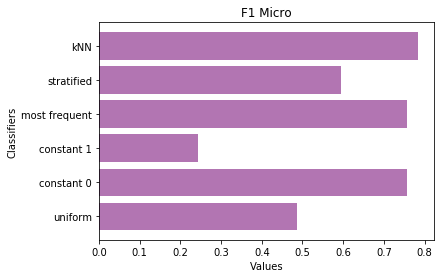

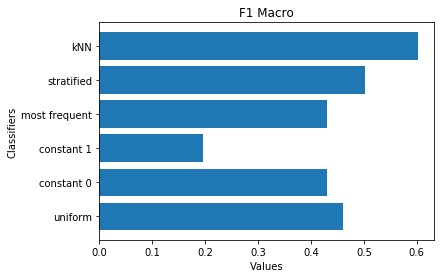

In [17]:
##Firstly for F1 Micro
# Split dictionary
names = list(baseline_f1_micro.keys())
values = list(baseline_f1_micro.values())
y_pos = np.arange(len(names))
# Create horizontal bars and color
plt.barh(y_pos, values, color = (0.5,0.1,0.5,0.6))
# Add names to axis
plt.title('F1 Micro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
# Create names
plt.yticks(y_pos, names)
# Show graphic
plt.show()

##Firstly for F1 Macro
# Split dictionary
names = list(baseline_f1_macro.keys())
values = list(baseline_f1_macro.values())
y_pos = np.arange(len(names))
# Create horizontal bars and color
plt.barh(y_pos, values)
# Add names to axis
plt.title('F1 Macro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
# Create names
plt.yticks(y_pos, names)
# Show graphic
plt.show()


3. Σχολιασμός αποτελεσμάτων:

Αρχικά θα συγκρίνουμε τα confuse matrices της κάθε τεχνικής ταξινόμησης. Όπως ήταν αναμενόμενο, τα matrices στον constant 0 και στον constant 1 είναι "συμπληρωματικα", και η συμπληρωματική στήλη της αντίστοιχης τεχνικής, είναι 0. Επίσης σημειώνουμε πως ο confusion matrix στην περίπτωση most frequent ταυτίζεται με τον matrix της constant 0, πράγμα που δικαιολογείται από το γεγονός πως η κλάση 0 εμφανίζει το μεγαλύτερο frequency στο dataset. Ο confusion matrix της τεχνικής uniform είναι ο πιο ομοιόφορφος συγκριτικά με τους υπόλοιπους, λόγω το ότι προβλέπει τυχαία και ομοιόμορφα, ενώ στην τεχνική stratified παρατηρούμε ότι η κλάση 0 έχει σημαντικά περισσότερες επιτυχείς προβλέψεις από την κλάση 1, επειδή η τεχνική stratified επιλέγει βάσει της συχνοτικής κατανομής των κλάσεων(και υπενθυμίζουμε πως η κλάση 0 υπερέχει συχνοτικά της 1).

Όσον αφορά το confusion matrix για την μέθοδο kNN neighbors, παρατηρούμε πως για την κλάση 0 έχουμε 24 επιτυχείς προβλέψεις, ενώ στην κλάση 1 έχουμε 2 επιτυχείς προβλέψεις. Το αποτέλεσμα αυτό μπορεί να εξηγηθεί βάσει του τρόπου που λειτουργεί η τεχνική kNN neighbors. Πιο συγκεκριμένα, τα δείγματα το εν λόγω dataset είναι αραιά κατανεμημένα (έχουμε χώρο 12 διαστάσεων και λιγότερο από 150 στοιχεία) και η συχνοτική υπεροχή της κλάσης 0 έναντι της κλάσης 1, προκαλεί την πιο αραιή κατανομή της κλάσης 1 στο χώρο. Δηλαδή, (εφόσον έχουμε k=5), απο τα 5 στοιχεία τα οποία έχουν την μικρότερη γεωμετρική απόσταση, θα πρέπει να 3 από αυτά να είναι κλάσης 1, κάτι που είναι δύσκολο να επιτευχθεί. 

Τέλος, όσον αφορά τα plots, συγκρίνοντας με μία πρώτη ματιά τα 2 plots βλέπουμε ότι έχουμε γενικότερα χαμηλότερα scores χρησιμοποιώντας f1_macro. Παρατηρούμε ότι στις τεχνικές most frequent και constant 0 υπάρχει η μεγαλύτερη διαφορά στα scores. Αυτό εξηγείται από το γεγονός πως λαμβάνουμε τον συνολικό μέσο όρο στα metrics, χωρίς η ποσότητα των δειγμάτων να επηρεάζει το αποτέλεσμα.(Στην f1_micro, έχουμε πολύ μεγαλύτερα scores λόγω του γεγονότος ότι τα περισσότερα δείγματα είναι κλάσης 0). Επίσης, στο kNN, όσο πιο ανισοκατανεμημένο είναι το dataset, παρατηρούμε καλύτερη πρόβλεψη της πιο συχνής κλάσης, για αυτό βλέπουμε και στον kNN μία μεγάλη διαφορά ανάμεσε στην f1_micro και στην f1_macro.

## Βελτιστοποίηση ταξινομητών 

Brute-forcing για έυρεση καλύτερου συνδυασμού παραμέτρων:

In [119]:
scaling = ['standard','min max','no']
oversampling = ['over', 'under', 'no']
pca_components = range(2, 13)
neighbors = list(filter(lambda x: x % 2 != 0, list(range(1, 12))))
#scoring = ['f1_micro', 'f1_macro']
f1_micro_scores = {}
f1_macro_scores = {}
# Variance Threshold
selector = VarianceThreshold()
train_reduced = selector.fit_transform(train)
for k in neighbors:
    # Scaling
    for sc in scaling:
        if sc == 'standard':
            scaler = StandardScaler().fit(train_reduced)
            train_scaled = scaler.transform(train_reduced)
        elif sc == 'min max':
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(train_reduced)
        elif sc == 'no':
            train_scaled = train_reduced
        # OverSampling
        for os in oversampling:
            if os == 'over':
                ros = RandomOverSampler()
                train_scaled_sampled, train_labels_sampled = ros.fit_resample(train_scaled, train_labels)
            elif os == 'under':
                rus = RandomUnderSampler()
                train_scaled_sampled, train_labels_sampled = rus.fit_resample(train_scaled, train_labels)
            elif os == 'no':
                train_scaled_sampled = train_scaled
                train_labels_sampled = train_labels
            # PCA
            for pca_n in pca_components:
                pca = PCA(pca_n)
                train_PCA = pca.fit_transform(train_scaled_sampled)
                #kNN
                knn = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, train_PCA, train_labels_sampled, cv=10, scoring="f1_micro")
                f1_micro_scores[(sc, os, pca_n, k)] = round(scores.mean(), 5)
                knn = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, train_PCA, train_labels_sampled, cv=10, scoring="f1_macro")
                f1_macro_scores[(sc, os, pca_n, k)] = round(scores.mean(), 5)

print("Scores for F1 micro :\n",f1_micro_scores)
print("\nScores for F1 macro :\n",f1_macro_scores)

Scores for F1 micro :
 {('standard', 'over', 2, 1): 0.82636, ('standard', 'over', 3, 1): 0.82545, ('standard', 'over', 4, 1): 0.80955, ('standard', 'over', 5, 1): 0.81091, ('standard', 'over', 6, 1): 0.84455, ('standard', 'over', 7, 1): 0.83455, ('standard', 'over', 8, 1): 0.83455, ('standard', 'over', 9, 1): 0.83455, ('standard', 'over', 10, 1): 0.83455, ('standard', 'over', 11, 1): 0.83455, ('standard', 'over', 12, 1): 0.83455, ('standard', 'under', 2, 1): 0.565, ('standard', 'under', 3, 1): 0.455, ('standard', 'under', 4, 1): 0.49, ('standard', 'under', 5, 1): 0.4375, ('standard', 'under', 6, 1): 0.4375, ('standard', 'under', 7, 1): 0.4275, ('standard', 'under', 8, 1): 0.44, ('standard', 'under', 9, 1): 0.44, ('standard', 'under', 10, 1): 0.44, ('standard', 'under', 11, 1): 0.44, ('standard', 'under', 12, 1): 0.44, ('standard', 'no', 2, 1): 0.63238, ('standard', 'no', 3, 1): 0.5628, ('standard', 'no', 4, 1): 0.5319, ('standard', 'no', 5, 1): 0.56899, ('standard', 'no', 6, 1): 0.6086

Στην συνέχεια βρίσκουμε τον καλύτερο συνδυασμό παραγόντων:

In [120]:
# Find best combination for F1 Micro
vals_f1_micro = list(f1_micro_scores.values())
keys_f1_micro = list(f1_micro_scores.keys())
best_f1_micro = keys_f1_micro[vals_f1_micro.index(max(vals_f1_micro))]

# Find best combination for F1 Macro
vals_f1_macro = list(f1_macro_scores.values())
keys_f1_macro = list(f1_macro_scores.keys())
best_f1_macro = keys_f1_macro[vals_f1_macro.index(max(vals_f1_macro))]

#Print Results
#F1 Micro
print("Best combination for F1 Micro :",best_f1_micro, "with value =",f1_micro_scores[best_f1_micro])
#F1 Macro
print("Best combination for F1 Macro :",best_f1_macro, "with value =", f1_macro_scores[best_f1_macro])

Best combination for F1 Micro : ('standard', 'over', 6, 1) with value = 0.84455
Best combination for F1 Macro : ('standard', 'over', 6, 1) with value = 0.83986


Όπως φαίνεται απο το καλύτερο αποτέλεσμα στο brute-force θα χρησιμοποιηθούν για το καλύτερο αποτέλεσμα οι μετασχηματιστές και ο ταξινομητής ως εξής με την σειρά που αναφέρονται:
1. Standard Sampling
2. OverSampling
3. PCA με την υπερπαράμετρο ίση με 2
4. Τέλος, ο kNN θα λαμβάνει υπόψιν μόνο τον κοντινότερο γείτονα.

Παρακάτω δίνεται ο κώδικας για όλο το pipeline το οποίο υλοποιείται ως μία συνάρτηση. Για την διευκόλυνση μας, η συνάρτηση αυτή δεν έχει fixed τις υπερπαραμέτρους και τον τύπο του ταξινομητή αλλά είναι αρκετά ευέλικτη ώστε να περιορίσουμε τον επαναλαμβανόμενο κώδικα. 


Η σειρά στο pipeline είναι η εξής:
    VarianceThreshold -> Scaling -> Sampling -> PCA -> Estimator

Το έχουμε κάνει με δυνατότητα επιλογής ταξινομητή ώστε να μπορούμε να έχουμε ως επιλογή να επιστρέφουνε και αποτελέσματα για τους dummies ταξινομητές. Δυνατές εισόδους για αυτό είναι:
1. 'knn' -> k Nearest Neighbors
2. 'uniform' -> Uniform Dummy
3. 'const0' -> Constant 0 Dummy
4. 'const1' -> Constant 1 Dummy
5. 'most freq' -> Most Frequent Dummy
6. 'strat' -> Statified Dummy

Η συνάρτηση run_pipeline δέχεται το dataset ήδη χωριζόμενο σε train και test και οπότε περνάμε σε κάθε κλήση της τους πίνακες αυτούς όπως χωρίστηκαν αρχικά. Άλλωστε, δεν χρησιμοποιούμε κάποια μέθοδο ή μετασχηματιστή που να χρειάζεται το dataset ενιαίο, όπως διαβάστηκε.

In [126]:
def run_pipeline(parameters, train, train_labels, test, test_labels, estimator):
    (sc, os , pca_n, neighbors) = parameters
    ## Variance Threshold  
    selector = VarianceThreshold()  #Initializing of a selector 
    train_reduced = selector.fit_transform(train)  # Fit the transformer and transform the data for the training
    test_reduced = selector.transform(test)   # Transorm the data for the final testing
    ## Scaling
    if sc == 'standard':   
        scaler = StandardScaler().fit(train_reduced)  # Initializing of Standard Scaler
        train_scaled = scaler.transform(train_reduced)
        test_scaled = scaler.transform(test_reduced)
    elif sc == 'min max':   
        scaler = MinMaxScaler()  # Initializing of Min Max Scaler
        train_scaled = scaler.fit_transform(train_reduced)
        test_scaled = scaler.transform(test_reduced)
    elif sc == 'no':
        train_scaled = train_reduced
        test_scaled = test_reduced  
    else:
        print("ERROR Scaling")
        return
    ## Sampling
    if os == 'over':        
        ros = RandomOverSampler()  # Initializing of RandomOverSampler
        train_scaled_sampled, train_labels_sampled = ros.fit_sample(train_scaled, train_labels)
    elif os == 'under':
        rus = RandomUnderSampler()
        train_scaled_sampled, train_labels_sampled = rus.fit_resample(train_scaled, train_labels)    
    elif os == 'no':
        train_scaled_sampled = train_scaled
        train_labels_sampled = train_labels
    else:
        print("ERROR Sampling")
        return
    ## PCA
    if pca_n == 0: # 0 -> no use of PCA
        train_PCA = train_scaled_sampled
        test_PCA = test_scaled
    elif pca_n > 0:
        pca = PCA(pca_n)
        # this transformation must be both on training and testing set, but the fitting only on training set
        train_PCA = pca.fit_transform(train_scaled_sampled)
        test_PCA = pca.transform(test_scaled)
    else:
        print("ERROR PCA")
        return
    # correct the names of the parameters for the classifiers (simpler)
    train = train_PCA
    train_labels = train_labels_sampled
    test = test_PCA
    ## Estimators
    if estimator == 'kNN':
        # K Neighbors Classifier
        knn = KNeighborsClassifier()
        t0 = time()
        knn.fit(train, train_labels)
        t1 = time()
        pred = knn.predict(test)
        t2 = time()
    elif estimator == 'uniform':
        # Uniform
        dc_uniform = DummyClassifier(strategy="uniform")
        t0 = time()
        model = dc_uniform.fit(train, train_labels)
        t1 = time()
        pred = dc_uniform.predict(test)
        t2 = time()
    elif estimator == 'constant 0':
        # Constant 0
        dc_constant_0 = DummyClassifier(strategy="constant", constant=0)
        t0 = time()
        model = dc_constant_0.fit(train, train_labels)
        t1 = time()
        pred = dc_constant_0.predict(test)        
        t2 = time()
    elif estimator == 'constant 1':
        # Constant 1
        dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
        t0 = time()
        model = dc_constant_1.fit(train, train_labels)
        t1 = time()
        pred = dc_constant_1.predict(test)
        t2 = time()
    elif estimator == 'most frequent':
        # Most Frequent
        dc_most_frequent = DummyClassifier(strategy="most_frequent")
        t0 = time()
        model = dc_most_frequent.fit(train, train_labels)
        t1 = time()
        pred = dc_most_frequent.predict(test)    
        t2 = time()
    elif estimator == 'stratified':
        # Stratified
        dc_stratified = DummyClassifier(strategy="stratified")
        t0 = time()
        model = dc_stratified.fit(train, train_labels)
        t1 = time()
        pred = dc_stratified.predict(test)
        t2 = time()
    else:
        print("ERROR Estimator")
        return
    ## Return the predictions of the classifier on the test set
    fit_time = round((t1 - t0) * 1000, 3)
    predict_time = round((t2 - t1) * 1000, 3)
    return pred, fit_time, predict_time

1. Επειδή βρήκαμε τις ίδιες παραμέτρους-αρχιτεκτονική για βέλτιστες τιμές σε f1 micro και macro τρέχουμε το run_pipeline μόνο μία φορά για το kNN. Παρακάτω, οι επιδόσεις του kNN και των dummy classifiers με τις βέλτιστες παραμέτρους: (παράλληλα αποθηκέυουμε και τους χρόνους εκτέλεσης των fit και predict)

In [128]:
best_param = best_f1_macro
print (best_f1_macro)
final_f1_micro = {}
final_f1_macro = {}
times_ms = {}

list_classifiers = ['uniform','constant 0', 'constant 1', 'most frequent', 'stratified', 'kNN']
for cl in list_classifiers:
    # run pipeline for cl estimator
    pred, fit_time, predict_time = run_pipeline(best_param, train, train_labels, test, test_labels, cl)
    # print conf matrix and save 
    print("\n",cl,"\n")
    print("Confusion matrix:\n",confusion_matrix(test_labels, pred))
    final_f1_micro[cl] = f1_score(test_labels, pred, average="micro")
    print("F1 micro score:",final_f1_micro[cl])
    final_f1_macro[cl] = f1_score(test_labels, pred, average="macro")
    print("F1 macro score:",final_f1_macro[cl])
    print("Metric scores and Averages:\n",classification_report(test_labels,pred))
    times_ms[cl] = (fit_time, predict_time)

('standard', 'over', 6, 1)

 uniform 

Confusion matrix:
 [[19  9]
 [ 7  2]]
F1 micro score: 0.5675675675675675
F1 macro score: 0.4518518518518519
Metric scores and Averages:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.18      0.22      0.20         9

   micro avg       0.57      0.57      0.57        37
   macro avg       0.46      0.45      0.45        37
weighted avg       0.60      0.57      0.58        37


 constant 0 

Confusion matrix:
 [[28  0]
 [ 9  0]]
F1 micro score: 0.7567567567567567
F1 macro score: 0.4307692307692308
Metric scores and Averages:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        28
           1       0.00      0.00      0.00         9

   micro avg       0.76      0.76      0.76        37
   macro avg       0.38      0.50      0.43        37
weighted avg       0.57      0.76      0.65        37


 constant 1 

Con

2. Ο χρόνος εκτέλεσης του fit και του predict σε milliseconds:

In [129]:
# print the fit and predict times in milliseconds
for k,v in times_ms.items():
    print (k, ":\n","Fit time =", v[0],"\n Predict time =", v[1])
    

uniform :
 Fit time = 0.273 
 Predict time = 0.096
constant 0 :
 Fit time = 0.276 
 Predict time = 0.053
constant 1 :
 Fit time = 0.447 
 Predict time = 0.093
most frequent :
 Fit time = 0.159 
 Predict time = 0.062
stratified :
 Fit time = 0.152 
 Predict time = 0.066
kNN :
 Fit time = 0.508 
 Predict time = 0.916


3. Στην συνέχεια δίνουμε τα bar plot σύγκρισης για τα f1-micro και f1-macro όπως και στο baseline. Με ΚΟΚΚΙΝΟ χρώμα οι τιμές απο την baseline ταξινόμηση και με ΠΡΑΣΙΝΟ οι νέες τιμές.

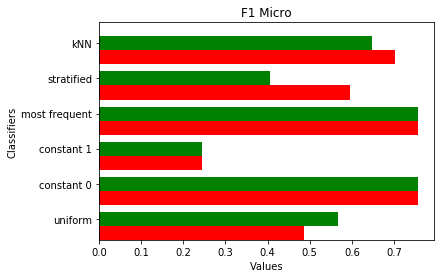

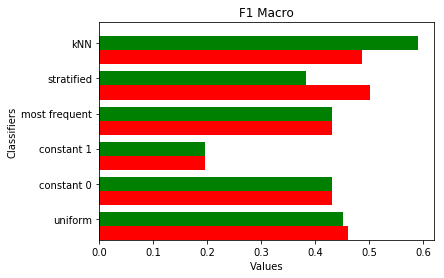

In [130]:
##Firstly for F1 Micro
names = list(final_f1_micro.keys())
prev_values = list(baseline_f1_micro.values())
values = list(final_f1_micro.values())
ind = np.arange(len(names))
width = 0.4
fig, ax = plt.subplots()
ax.barh(ind, prev_values, width, color='red', label='Baseline')
ax.barh(ind + width, values, width, color='green', label='Optimised')
plt.title('F1 Micro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
ax.set(yticks=ind + width, yticklabels=names, ylim=[2*width - 1, len(names)])
plt.show()

##Firstly for F1 Macro
names = list(final_f1_macro.keys())
prev_values = list(baseline_f1_macro.values())
values = list(final_f1_macro.values())
ind = np.arange(len(names))
width = 0.4
fig, ax = plt.subplots()
ax.barh(ind, prev_values, width, color='red', label='Baseline')
ax.barh(ind + width, values, width, color='green', label='Optimised')
plt.title('F1 Macro')
plt.ylabel('Classifiers')
plt.xlabel('Values')
ax.set(yticks=ind + width, yticklabels=names, ylim=[2*width - 1, len(names)])
plt.show()


4. Υπολογίζουμε την μεταβολή των επιδόσεων και δημιουργούμε ένα dictionary για τα f1 micro scores και ένα για τα f1 macro scores.

In [131]:
f1_micro_change = {}
f1_macro_change = {}
for key in final_f1_micro.keys():
    f1_micro_change[key] = final_f1_micro[key] - baseline_f1_micro[key]
    f1_macro_change[key] = final_f1_macro[key] - baseline_f1_macro[key]

print("Changes for classifiers for f1 micro :\n",f1_micro_change)
print("Changes for classifiers for f1 macro :\n",f1_macro_change)

Changes for classifiers for f1 micro :
 {'uniform': 0.08108108108108103, 'constant 0': 0.0, 'constant 1': 0.0, 'most frequent': 0.0, 'stratified': -0.1891891891891892, 'kNN': -0.05405405405405406}
Changes for classifiers for f1 macro :
 {'uniform': -0.009450830140485256, 'constant 0': 0.0, 'constant 1': 0.0, 'most frequent': 0.0, 'stratified': -0.11801437556154548, 'kNN': 0.10318118145882188}


5. Σχολιασμός αποτελεσμάτων

Θα ξεκινήσουμε από τα τελικά plots. Παρατηρώντας το f1_micro plot, παρατηρούμε πως έπεσε η απόδοση στον kNN και στον stratified, ενώ αυξήθηκε στον uniform. Η αύξηση στον uniform εξηγείται από το γεγονός πως ο uniform προβλέπει τυχαία και κατανεμημένα, και εφόσον το τελικό μας δείγμα είναι πιο ομοιόμορφα κατανεμημένο, αυξήθηκε το score του uniform. Όσον αφορά τους άλλους 2, γνωρίζουμε γενικά πως η f1 micro επηρεάζεται πάρα πολύ από ανισόρροπα δείγματα. Με τη βελτιστοποίηση και εξομάλυνση, παρατηρούμε πως ο kNN και ο stratified έχουν λιγότερη απόδοση, διότι ενδεχομένως αυτή η "εξομάλυνση" μειώνει την πρόβλεψη της πιο συχνής κλάσης (το ¨δυνατό χαρτί" του kNN, και η φιλοσοφία του stratified). Στα υπόλοιπα dummies, δεν παρατηρούμε καμία αξιοσημείωτη μεταβολή.

Πηγαίνοντας στο f1_macro plot, βλέπουμε αντίθετη συμπεριφορά για τον kNN. Συγκεκριμένα, βλέπουμε πως ο kNN έχει με διαφορά το καλύτερο σκόρ. Το oversampling σε συνδυασμό με την εξομάλυνση του dataset ανέβασε την απόδοση του kNN. Όσον αφορά τα dummies, παρατηρούμε μία αισθητή πτώση στο stratified και στο uniform, διότι το oversampling και η βελτιστοποίηση εξομάλυναν την κατανομή των κλάσεων. 

Στα confusion matrices, εν συγκρίσει με το baseline classification, παρατηρούμε πως για τα constant και για το most_frequent έχουν μείνει ίδια(και για αυτό στα plot μας δεν παρατηρειται καμία μεταβολή). Ο uniform βλέπουμε πως έχει περισσότερες επιτυχείς προβλέψεις στην κλάση 0 και λιγότερες στην κλάση 1. Οι stratified και kNN βλέπουμε πως έχουν πιο ομαλή κατανομή στις επιτυχείς προβλέψεις των κλάσεων 0 και 1 εν συγκρίσει με το baseline, λόγω του oversampling και της βελτιστοποίησης.

Όσον αφορά τωρα τους χρόνους απόδοσης, όπως είναι λογικό τον μεγαλύτερο χρόνο σκοράρει ο kNN τόσο στο fit όσο και στο predict, λόγω του αλγορίθμου που υλοποιεί για τη βελτιστοποίηση του dataset, ενώ ακολουθεί ο constant 1 στο fit, διότι η κλάση 1 αρχικά έχει συχνότητα της τάξης του 20%. Συγκρίνοντας το predict time του kNN και των dummy classifiers, βλέπουμε ότι το predict time στους dummy είναι πολύ μικρότερο σε σχέση με τον kNN.